In [1]:
import numpy as np
import os
import cv2
import glob

# Path to your image dataset
IMAGE_FOLDER = "train/"  
OUTPUT_IMAGES = "images.npy"

# Improved Preprocessing Function
def preprocess_image(image):
    # Apply a stronger Median Blur to remove salt-and-pepper noise
    median_blurred = cv2.medianBlur(image, 9)  # Increased kernel size to remove more noise

    # Use Bilateral Filter instead of Gaussian Blur for better edge preservation
    filtered = cv2.bilateralFilter(median_blurred, 9, 75, 75)

    # Apply Canny Edge Detection
    edges = cv2.Canny(filtered, threshold1=75, threshold2=120)

    # Soften edges by applying a slight blur to the edge map
    edges_blurred = cv2.GaussianBlur(edges, (5, 5), 0)

    # Normalize edges and blend with filtered image
    edges_blurred = edges_blurred.astype(np.float32) / 255.0
    enhanced = filtered * (1 + 0.3 * edges_blurred)  # Lowered edge boost to avoid artifacts

    # Normalize and clip values
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)
    
    return enhanced

# Convert images to NumPy array
def create_numpy_dataset(image_folder, output_images):
    image_paths = sorted(glob.glob(os.path.join(image_folder, "img_*.png")))  
    print(f"Found {len(image_paths)} images.")

    images = []

    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))  

        # Apply improved preprocessing
        preprocessed = preprocess_image(image)

        # Expand dims for CNN compatibility
        preprocessed = np.expand_dims(preprocessed, axis=-1)

        images.append(preprocessed)

    images = np.array(images, dtype=np.float32)  

    np.save(output_images, images)
    print(f"Saved images to {output_images}")

# Run the conversion with preprocessing
create_numpy_dataset(IMAGE_FOLDER, OUTPUT_IMAGES)

# Load and check dataset
X = np.load("images.npy")
print(f"Loaded images shape: {X.shape}")  


Found 2000 images.
Saved images to images.npy
Loaded images shape: (2000, 256, 256, 1)


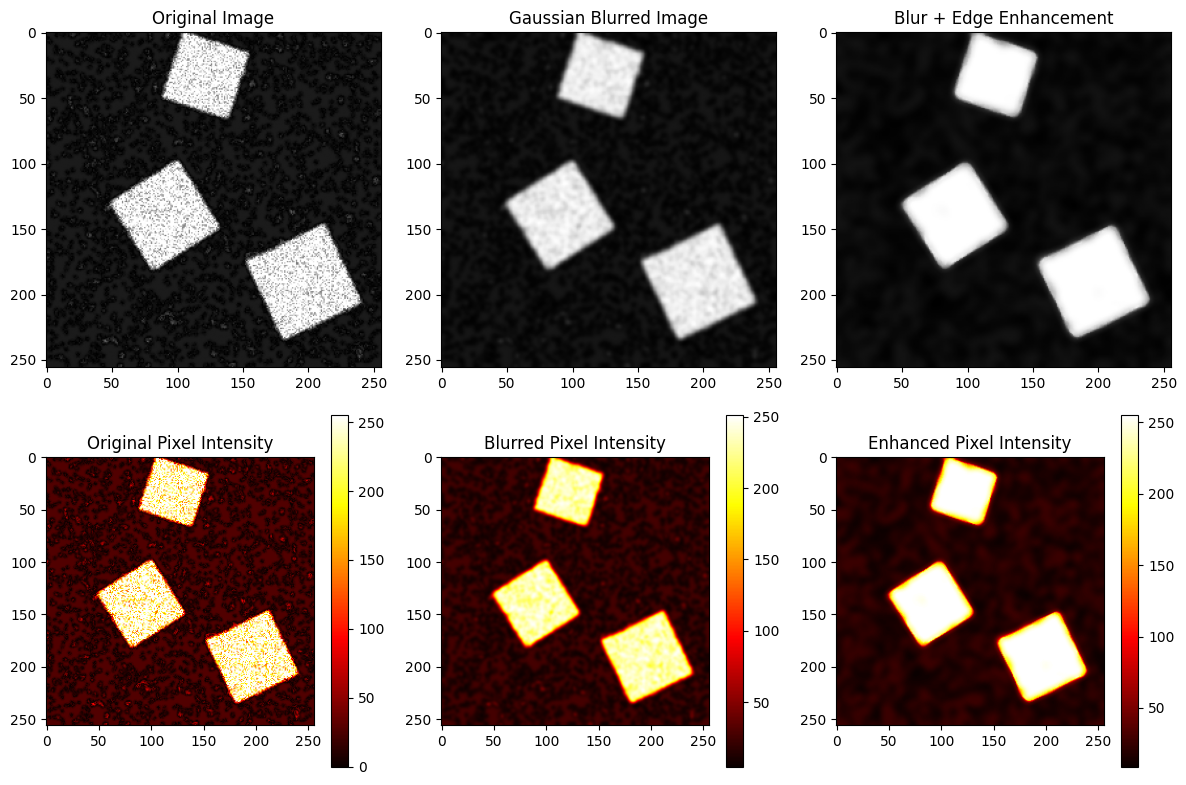

In [2]:
import matplotlib.pyplot as plt

# Load first image for visualization
original_image = cv2.imread(os.path.join(IMAGE_FOLDER, "img_1.png"), cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (256, 256))  # Ensure same size
blurred_image = cv2.GaussianBlur(original_image, (7, 7), 0)
processed_image = preprocess_image(original_image)  # Preprocessed with edge enhancement

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Show images
axes[0, 0].imshow(original_image, cmap="gray")
axes[0, 0].set_title("Original Image")

axes[0, 1].imshow(blurred_image, cmap="gray")
axes[0, 1].set_title("Gaussian Blurred Image")

axes[0, 2].imshow(processed_image, cmap="gray")
axes[0, 2].set_title("Blur + Edge Enhancement")

# Plot pixel intensity as heatmap
im1 = axes[1, 0].imshow(original_image, cmap="hot")
axes[1, 0].set_title("Original Pixel Intensity")
fig.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(blurred_image, cmap="hot")
axes[1, 1].set_title("Blurred Pixel Intensity")
fig.colorbar(im2, ax=axes[1, 1])

im3 = axes[1, 2].imshow(processed_image, cmap="hot")
axes[1, 2].set_title("Enhanced Pixel Intensity")
fig.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.show()


In [3]:
X = X / 255.0
print(X)

[[[[0.09803922]
   [0.09803922]
   [0.09411765]
   ...
   [0.09019608]
   [0.09019608]
   [0.09019608]]

  [[0.09411765]
   [0.09411765]
   [0.09411765]
   ...
   [0.09019608]
   [0.09019608]
   [0.09019608]]

  [[0.09411765]
   [0.09411765]
   [0.09019608]
   ...
   [0.08627451]
   [0.08627451]
   [0.08627451]]

  ...

  [[0.10588235]
   [0.10196079]
   [0.10196079]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]

  [[0.10588235]
   [0.10588235]
   [0.10588235]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]

  [[0.10588235]
   [0.10588235]
   [0.10588235]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]]


 [[[0.01176471]
   [0.01568628]
   [0.01568628]
   ...
   [0.02352941]
   [0.01960784]
   [0.01960784]]

  [[0.01176471]
   [0.01568628]
   [0.01568628]
   ...
   [0.02352941]
   [0.01960784]
   [0.01960784]]

  [[0.01568628]
   [0.01568628]
   [0.01568628]
   ...
   [0.01960784]
   [0.01960784]
   [0.01568628]]

  ...

  [[0.05882353]
   [0.05882353]
   [0.0

In [4]:
import pandas as pd
df = pd.read_csv("train_gt.csv")

Y = df.iloc[:, 1].values
print("Y pre normalization:", Y)

## normalizing

##Y_train_mean = np.mean(Y_train)
##Y_train_std = np.std(Y_train)

##Y_train_normalized = (Y_train - Y_train_mean) / Y_train_std  # Use this for training
##print("Y_train post normalization:", Y_train_normalized)

Y pre normalization: [3 3 3 ... 1 6 1]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
print("Y_train shape: ", Y_train.shape)
print("Y_test shape: ", Y_test.shape)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

from tensorflow.keras.utils import to_categorical

# Assuming Y_train and Y_test are integer labels (e.g., 0 to 15)
num_classes = 16  # Since the output layer has 16 neurons

Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)


Y_train shape:  (1600,)
Y_test shape:  (400,)
X_train shape:  (1600, 256, 256, 1)
X_test shape:  (400, 256, 256, 1)


In [7]:

print(X_train.shape, X_test.shape)
print("Y_train shape: ", Y_train.shape)
print("Y_test shape: ", Y_test.shape)

(1600, 256, 256, 1) (400, 256, 256, 1)
Y_train shape:  (1600, 16)
Y_test shape:  (400, 16)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

model = Sequential([
    # Block 1
    Input(shape=(256, 256, 1)),
    Conv2D(16, (7, 7), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(16, (7, 7), activation='relu', padding='same'),
    BatchNormalization(),
    AveragePooling2D((4, 4), strides=2),
    # Block 2
    Conv2D(32, (7, 7), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (7, 7), activation='relu', padding='same'),
    BatchNormalization(),
    AveragePooling2D((4, 4), strides=2),

    # Block 3
    Conv2D(64, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    AveragePooling2D((4, 4), strides=2),


    # Global Feature Extraction
    GlobalAveragePooling2D(),
    ##Dropout(0.2),  # Dropout to prevent overfitting

    # Fully Connected Layers
    Dense(64, activation='relu'),
    ##Dropout(0.3),

    # Output Layer
    Dense(16, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 16)        │          12,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 127, 127, 32)        │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 127, 127, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 127, 127, 32)        │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 127, 127, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 62, 62, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 30, 30, 64)          │               0 │
│ (AveragePooling2D)                   │                             │              

 Total params: 351,232 (1.34 MB)

 Trainable params: 350,656 (1.34 MB)

 Non-trainable params: 576 (2.25 KB)

In [9]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.005)

model.compile(
              optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
             )

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce LR when validation loss stops improving
    factor=0.5,          # Reduce LR by a factor of 0.5 (halve it)
    patience=3,          # Wait 3 epochs before reducing LR
    min_lr=1e-5          # Don't let it go below 0.00001
)

In [10]:
model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=16,
    verbose=2,  # Change to 2 for more details
    callbacks=[lr_scheduler]
)


Epoch 1/20
100/100 - 69s - 694ms/step - accuracy: 0.2319 - loss: 1.9112 - learning_rate: 0.0050
Epoch 2/20


C:\Users\prate\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


100/100 - 65s - 650ms/step - accuracy: 0.2569 - loss: 1.7801 - learning_rate: 0.0050
Epoch 3/20
100/100 - 63s - 632ms/step - accuracy: 0.2594 - loss: 1.7475 - learning_rate: 0.0050
Epoch 4/20
100/100 - 67s - 673ms/step - accuracy: 0.2419 - loss: 1.7566 - learning_rate: 0.0050
Epoch 5/20
100/100 - 67s - 674ms/step - accuracy: 0.2406 - loss: 1.7515 - learning_rate: 0.0050
Epoch 6/20
100/100 - 69s - 687ms/step - accuracy: 0.2575 - loss: 1.7369 - learning_rate: 0.0050
Epoch 7/20
100/100 - 69s - 688ms/step - accuracy: 0.2544 - loss: 1.7315 - learning_rate: 0.0050
Epoch 8/20
100/100 - 71s - 710ms/step - accuracy: 0.2562 - loss: 1.7356 - learning_rate: 0.0050
Epoch 9/20
100/100 - 68s - 680ms/step - accuracy: 0.2625 - loss: 1.7268 - learning_rate: 0.0050
Epoch 10/20


KeyboardInterrupt: 

In [11]:
Y_pred = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 391ms/step


In [12]:
print(Y_pred[0])
Y_pred = np.argmax(Y_pred, axis=1)
##Y_pred = (Y_pred_normalized * Y_train_std) + Y_train_mean
##Y_pred_final = np.maximum(0, np.round(Y_pred))  # Ensure non-negative, rounded values
print(Y_pred)

[3.2392561e-02 1.7363690e-01 4.0377739e-01 1.6664301e-01 1.7941235e-01
 3.4476444e-02 6.9515291e-03 2.6512810e-03 4.0021146e-06 3.4387151e-06
 6.0904777e-06 1.2681292e-05 6.0594475e-06 5.6145418e-06 1.1460570e-05
 9.2079581e-06]
[2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 4 2 2 2
 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 4 2 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 4 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2
 3 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2
 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 3 2 2 2 2 2 2 4 2 2 4 4 2 2 2 4 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2
 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2
 2 4 2 2 2 1 2 2 2 2 

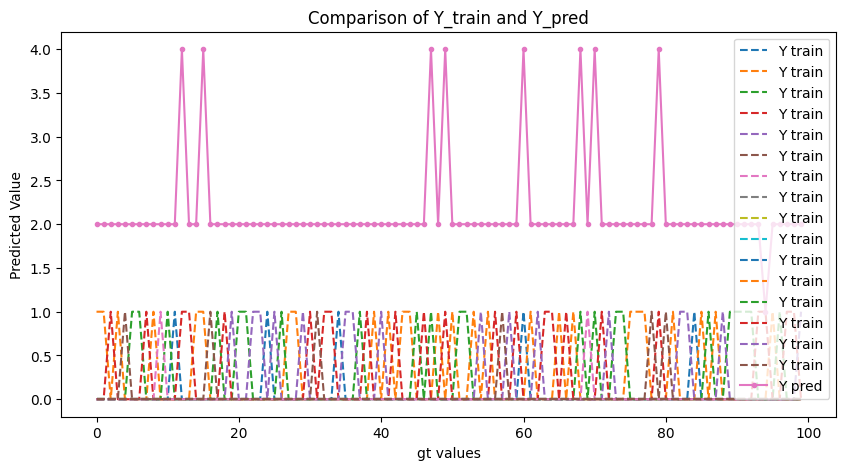

In [13]:
import matplotlib.pyplot as plt
Y_test_values = Y_test[:100]

Y_pred_values = Y_pred[:100]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(100), Y_test_values, label="Y train", linestyle="dashed")
plt.plot(range(100), Y_pred_values, label="Y pred", marker="o", markersize=3)

plt.xlabel("gt values")
plt.ylabel("Predicted Value")
plt.title("Comparison of Y_train and Y_pred")
plt.legend()
plt.show()

In [14]:
def accuracy_score(y_true, y_pred):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Ensure they have the same length
    assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"
    
    # Compute accuracy
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / len(y_true)
    
    return accuracy

score = accuracy_score(Y_test, Y_pred)
print("score is", score)

ValueError: operands could not be broadcast together with shapes (400,16) (400,) 

In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the test images folder
test_folder = "C:\Users\prate\Code\test"

# Image dimensions (same as model input)
IMG_SIZE = (256, 256)  # Adjust if needed

# Load images from "test" folder
test_images = sorted(os.listdir(test_folder))  # Ensures sorted order

X_submission = []
image_names = []

for i, filename in enumerate(test_images):
    img_path = os.path.join(test_folder, filename)
    
    # Load and preprocess the image
    img = load_img(img_path, color_mode="grayscale", target_size=IMG_SIZE)  # Convert to grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    X_submission.append(img_array)
    
    # Store the image name as "img_1", "img_2", ...
    image_names.append(f"img_{i+1}")

# Convert list to numpy array
X_submission = np.array(X_submission)

# Ensure correct shape
X_submission = X_submission.reshape(len(X_submission), IMG_SIZE[0], IMG_SIZE[1], 1)  # (60000, 256, 256, 1)

print("X_submission shape:", X_submission.shape)  # Should be (60000, 256, 256, 1)

# Run predictions
Y_submission = model.predict(X_submission)  # Shape: (60000, 16) if softmax output

# Convert one-hot predictions to class labels (0-15)
Y_submission = np.argmax(Y_submission, axis=1)

# Create DataFrame for submission
df_submission = pd.DataFrame({"Image Name": image_names, "Predicted Label": Y_submission})

# Save as Excel file
df_submission.to_excel("submission.xlsx", index=False)

print("Predictions saved to submission.xlsx")


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2413860390.py, line 4)